In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.drop(columns=['customerID'], inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Churn']).columns.tolist()


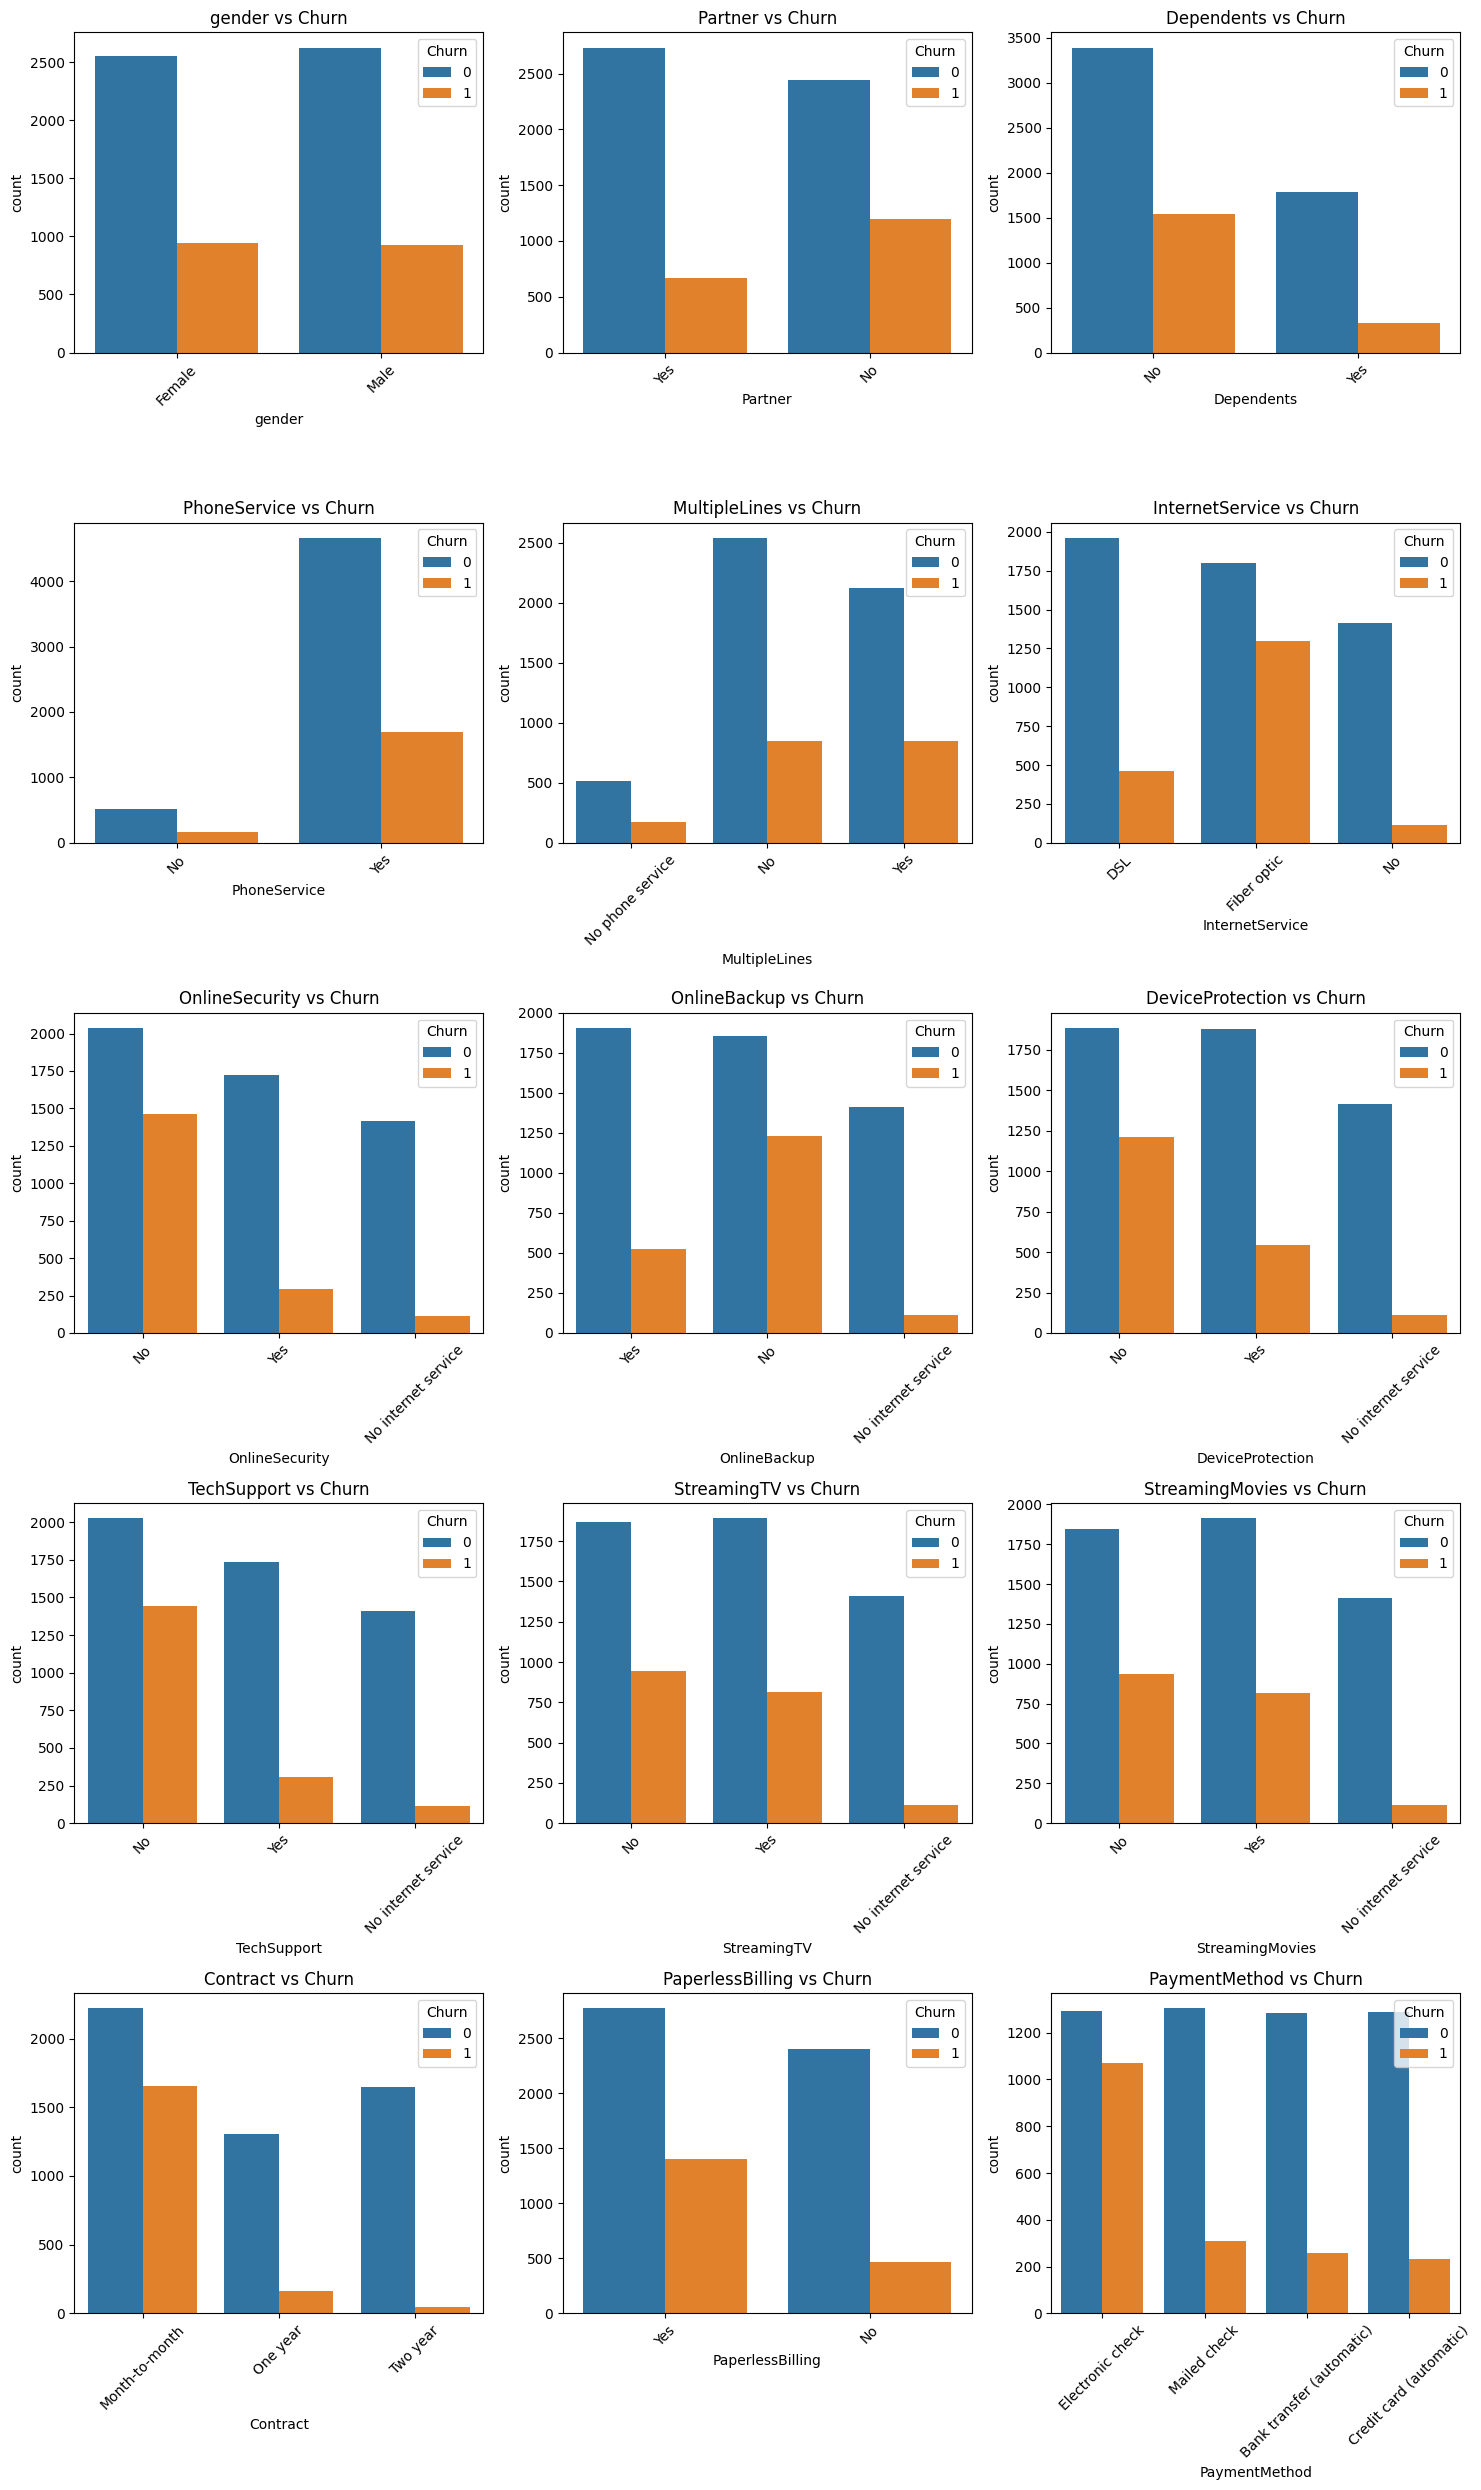

In [4]:
import math

num_features = len(categorical_features)
rows = math.ceil(num_features / 3)  
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15, 5 * rows))  
axes = axes.flatten()  

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='Churn', data=df, ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_title(f'{feature} vs Churn')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


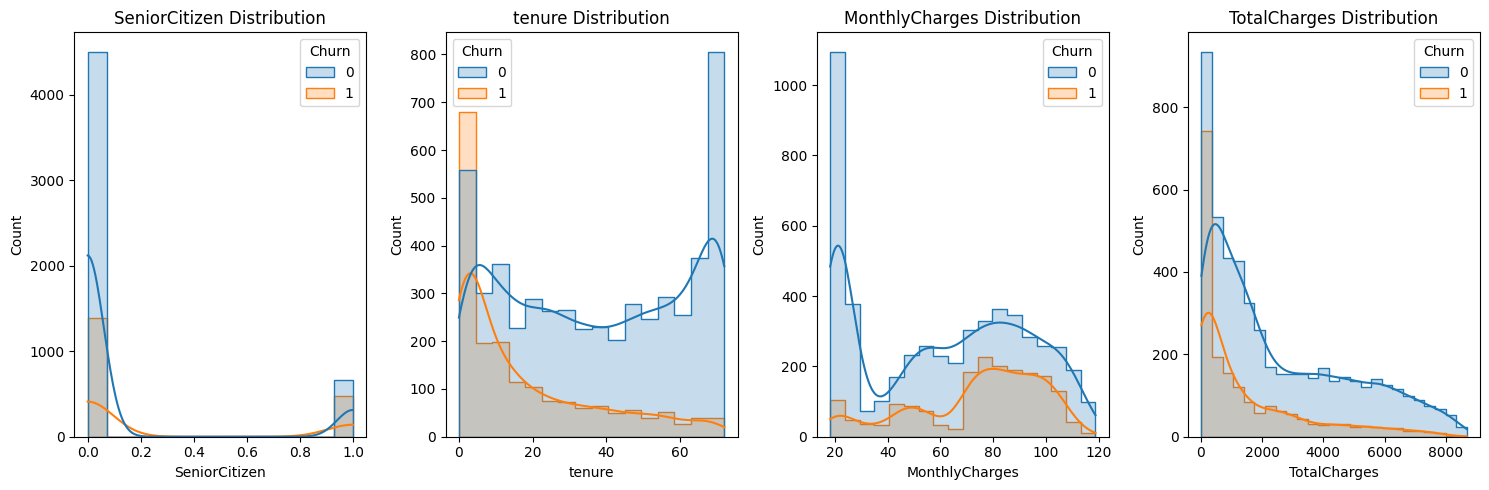

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_features), figsize=(15, 5))

if len(numerical_features) == 1:
    axes = [axes]

for i, feature in enumerate(numerical_features):
    sns.histplot(df, x=feature, hue='Churn', kde=True, element='step', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution')

plt.tight_layout()
plt.show() 


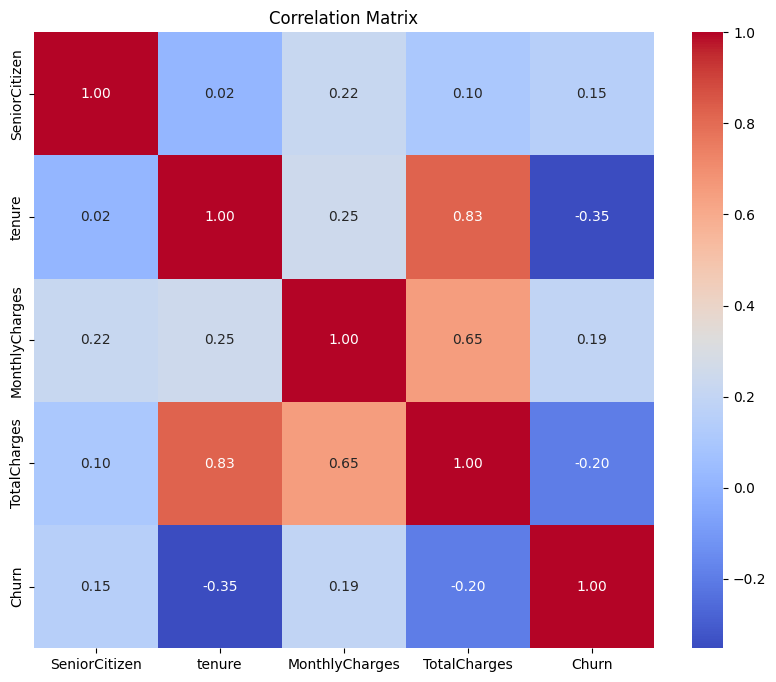

In [6]:
# 상관관계

plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features + ['Churn']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [7]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [8]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_prep, y_train)

  File "c:\Users\color\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\color\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\color\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                

In [10]:
#Evaluate model performance
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    print(f"\n📊 {model_name} 성능:")
    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f} | AUC: {roc_auc:.4f}")
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return {'model_name': model_name, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': roc_auc, 'fpr': fpr, 'tpr': tpr}


In [11]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}


 Logistic Regression 훈련 중...

📊 Logistic Regression 성능:
Accuracy: 0.8055 | Precision: 0.6572 | Recall: 0.5588 | F1 Score: 0.6040 | AUC: 0.8419


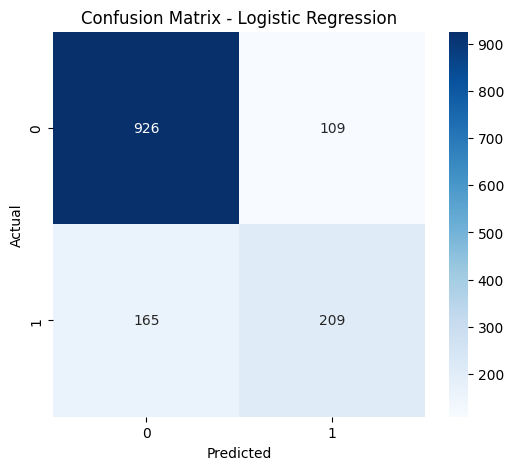


 Random Forest 훈련 중...

📊 Random Forest 성능:
Accuracy: 0.7779 | Precision: 0.6034 | Recall: 0.4759 | F1 Score: 0.5321 | AUC: 0.8164


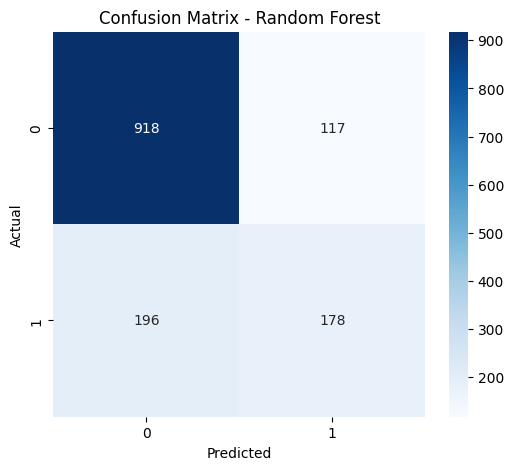


 Gradient Boosting 훈련 중...

📊 Gradient Boosting 성능:
Accuracy: 0.8062 | Precision: 0.6735 | Recall: 0.5241 | F1 Score: 0.5895 | AUC: 0.8432


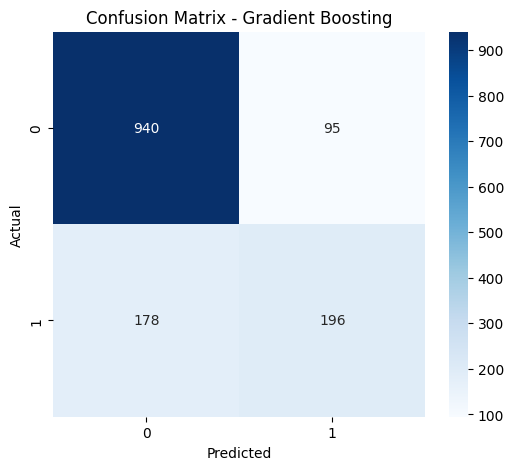


 XGBoost 훈련 중...

📊 XGBoost 성능:
Accuracy: 0.7736 | Precision: 0.5868 | Recall: 0.4973 | F1 Score: 0.5384 | AUC: 0.8217


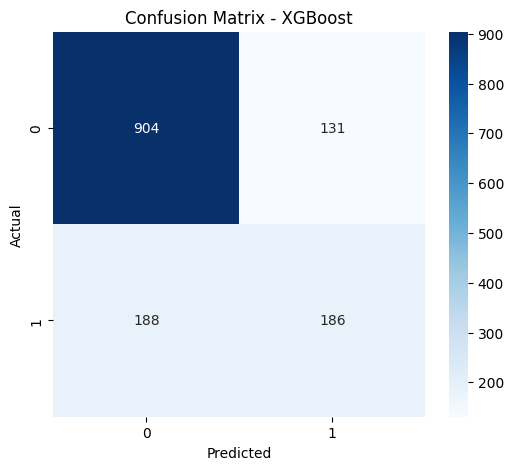


 SVM 훈련 중...

📊 SVM 성능:
Accuracy: 0.7913 | Precision: 0.6418 | Recall: 0.4840 | F1 Score: 0.5518 | AUC: 0.7905


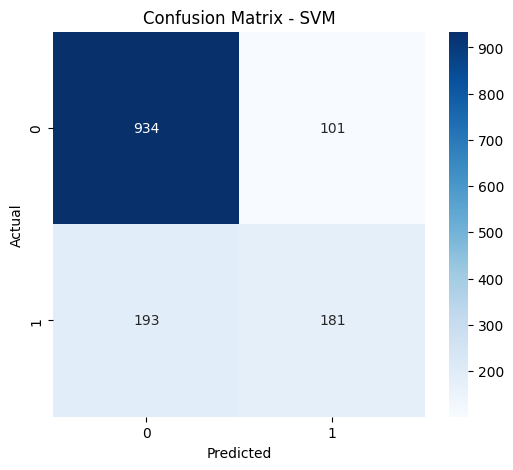

In [12]:
results = []
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

for model_name, model in models.items():
    print(f"\n {model_name} 훈련 중...")
    model.fit(X_train_prep, y_train)
    results.append(evaluate_model(model, X_test_prep, y_test, model_name))

In [ ]:
# 하이퍼파라미터 튜닝 (Random Forest 최적화)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), 
                           param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1) 
grid_search.fit(X_train_resampled, y_train_resampled) 
print("\n 최적 파라미터:", grid_search.best_params_)

best_model = grid_search.best_estimator_
results.append(evaluate_model(best_model, X_test_prep, y_test, "Optimized Random Forest"))


Fitting 5 folds for each of 18 candidates, totalling 90 fits



📊 Ensemble Model 성능:
Accuracy: 0.7821 | Precision: 0.5852 | Recall: 0.6150 | F1 Score: 0.5997 | AUC: 0.8338


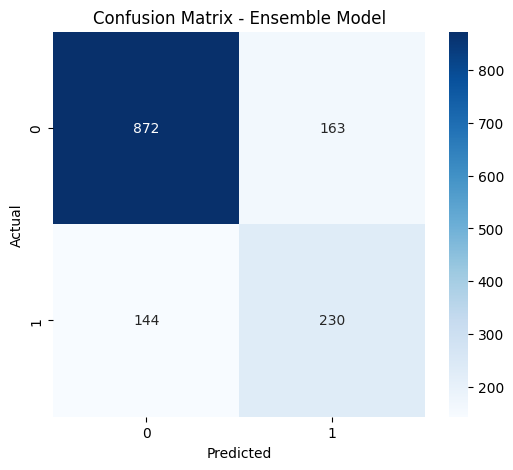

In [ ]:
ensemble_model = VotingClassifier(estimators=[
    ('rf', best_model),
    ('xgb', XGBClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
], voting='soft')
ensemble_model.fit(X_train_resampled, y_train_resampled)
results.append(evaluate_model(ensemble_model, X_test_prep, y_test, "Ensemble Model"))


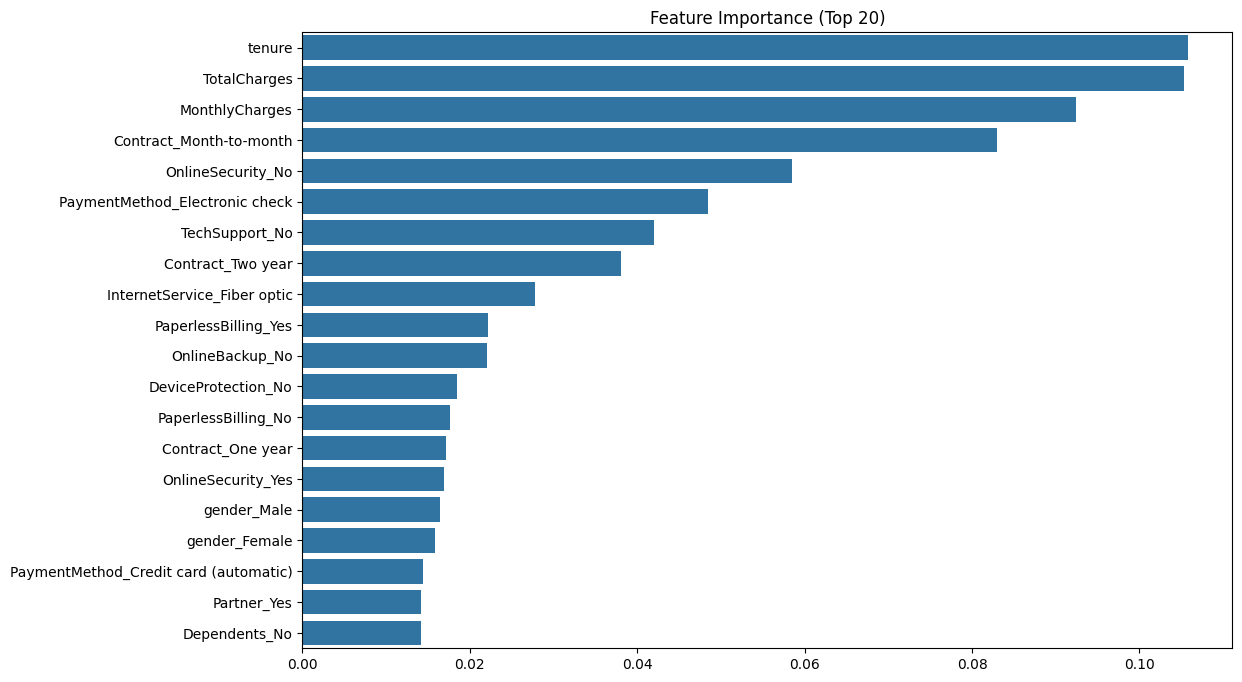

In [ ]:
if hasattr(best_model, 'feature_importances_'):
    feature_names = numerical_features + preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    importances = best_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 8))
    sns.barplot(y=np.array(feature_names)[sorted_idx][:20], x=importances[sorted_idx][:20])
    plt.title('Feature Importance (Top 20)')
    plt.show()